In [27]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())
library(cowplot)
# library(ggpubr)

In [28]:
setwd('/home/n10927662/rossenzhao/lyrebird-benchmarking')

In [29]:
# from plot.ipynb in folder 2
novelty_benchmark_results = fread('4_known_species_marine/bray-curtis.csv')
table(novelty_benchmark_results$tool)


lyrebird 
      70 

In [30]:
tools=c('lyrebird', 'metaphlan4', 'phanta')
correct_taxonomy_tools = c('lyrebird')

publication_names = data.table(
    tool = tools,
    publication_name = c('Lyrebird', 'MetaPhlAn4', 'Phanta')
    # publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [31]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [32]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
# d1[1:3]
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
base_dir = './'
readit = function(tool, community){
    to_read = paste(base_dir, '4_known_species_marine/','output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
lyrebird,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
lyrebird,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
lyrebird,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [33]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
# d3[1:3]
# dim(d3)
bc = d3[metric=='Bray-Curtis distance']
# dim(bc)
# bc[1:10]
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
bray_curtis = qplot(data=bcc, rank, value, ylim=c(0.4,0), geom='boxplot', color=tool, ylab='Bray-Curtis dissimilarity') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(legend.position = "none")

In [34]:
# tool comparison of species taxon counts to gold standard
counts_to_truths = fread("4_known_species_marine/species_count_to_truths.csv")
counts_to_truths_long <- melt(counts_to_truths, id.vars = NULL, variable.name = "tool", value.name = "value")
# rename the tools to their publication names
counts_to_truths_long$tool <- name_to_publication_name(counts_to_truths_long$tool)

# Create the boxplot
species_counts = ggplot(counts_to_truths_long, aes(x = tool, y = value, color = tool)) +
  geom_boxplot() +
  labs(y = "tool to gold standard species count", x = "Tool") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(legend.position = "none")

Warning message in melt.data.table(counts_to_truths, id.vars = NULL, variable.name = "tool", :
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns []. Consider providing at least one of 'id' or 'measure' vars in future.”


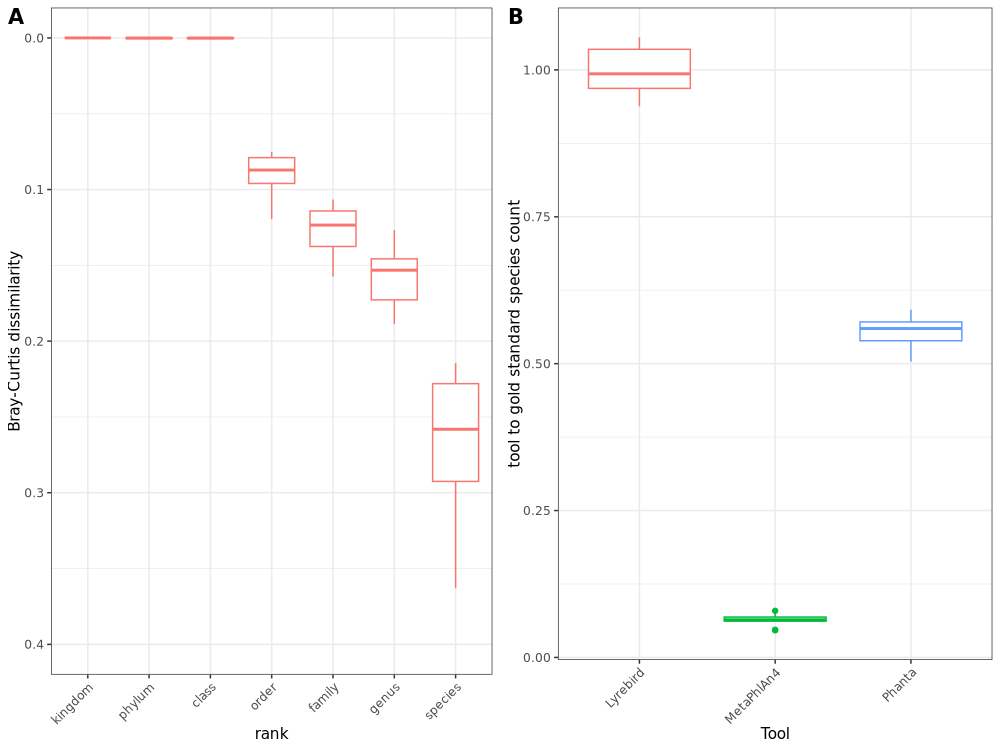

In [35]:
options(repr.plot.width = 10, repr.plot.height = 7.5, repr.plot.res = 100)
plot_grid(bray_curtis, species_counts, ncol = 2, labels = c("A", "B"), label_size = 15)

### Runtime Comparison ### 

In [36]:
thread_numbers = as.character(c(1,8,32))
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
# r1[1:3]
# r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir, '4_known_species_marine/','benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
r2[, tool := name_to_publication_name(tool)]

getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/rossenzhao/lyrebird-benchmarking"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lyrebird,1,marine0,491.0695,0:08:11,879.23,2582.16,865.11,866.32,2711.96,66.14,30.61,120.59
MetaPhlAn4,1,marine0,442.2937,0:07:22,35358.61,36471.50,35301.22,35312.40,4722.77,704.08,68.92,111.83
Phanta,1,marine0,41.3617,0:00:41,28661.15,31006.07,28646.07,28652.61,3.86,0.04,34.73,14.87


In [37]:
r1[33]
reed(tool = 'phanta', threads = '8', community = 'marine3')

tool,threads,community
<fct>,<fct>,<fct>
phanta,8,marine3


s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51.0353,0:00:51,135.67,1317.22,129.95,131.3,94.76,35.68,3.65,1.68


In [38]:
runtime = qplot(data=r2, threads, s/60, geom='boxplot', color=tool, ylab='Walltime (minutes)') + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + theme(legend.position= 'bottom')
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
mem_usage = qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='threads', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32)) + theme(legend.position= 'bottom')

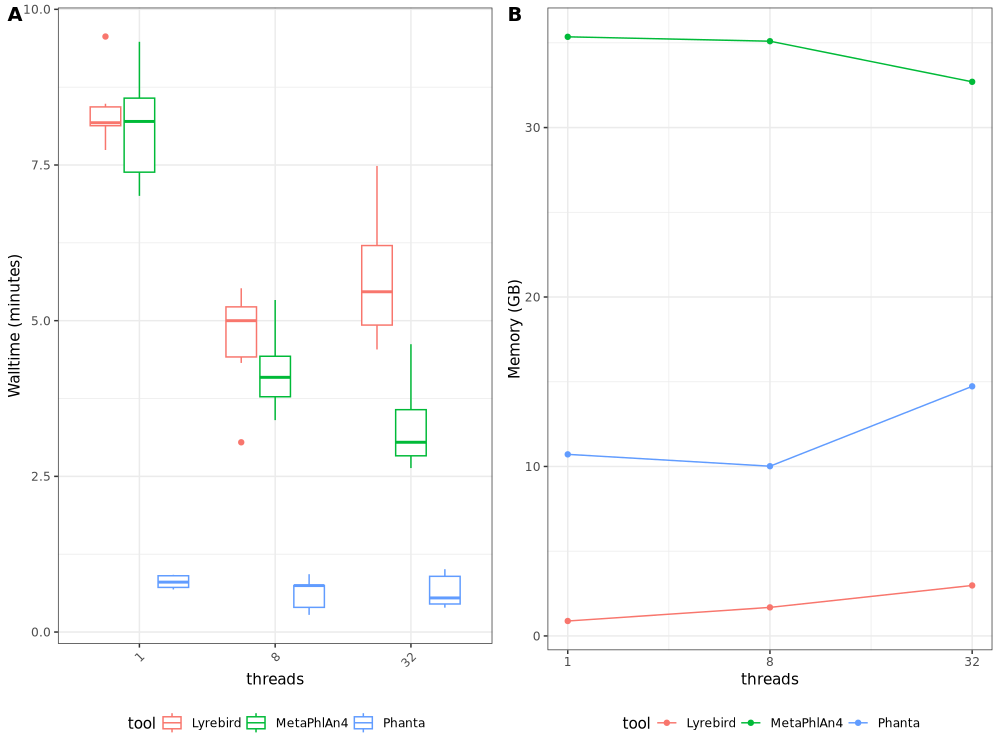

In [39]:
plot_grid(runtime, mem_usage, labels="AUTO")

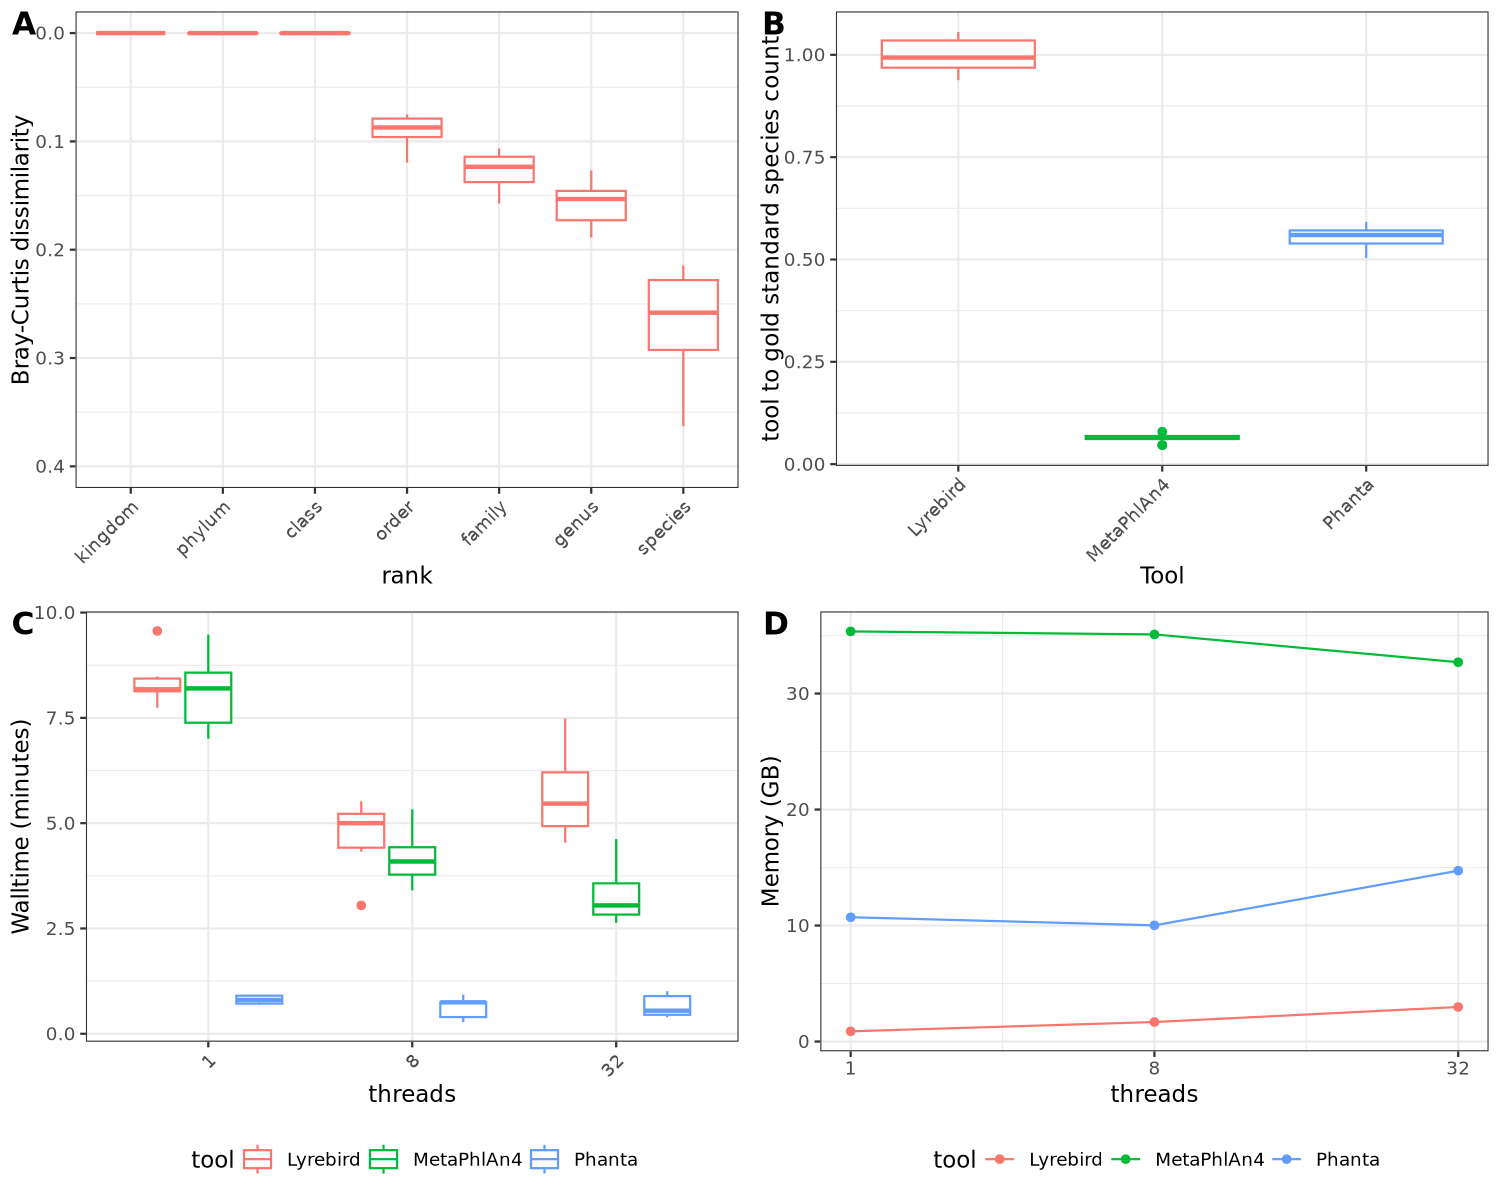

In [40]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150)
plot_grid(bray_curtis, species_counts, runtime, mem_usage, ncol = 2, nrow = 2, labels = c("A", "B", "C", "D"), label_size = 15)

### New random 100 ICTV species investigation ###

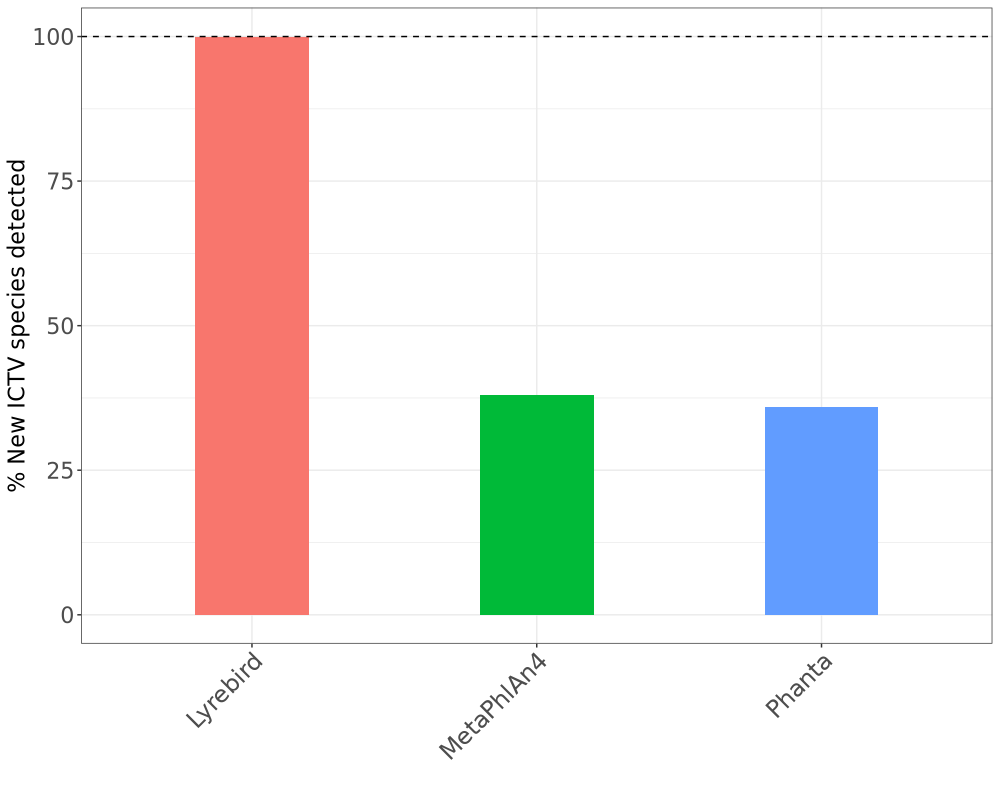

In [41]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)
novelty_counts = fread('6_novel_species_1_component/genome_counter.csv', )

# bar chart, add line at 100
novelty_counts$tool <- name_to_publication_name(novelty_counts$tool)

novelty_counts$tool <- factor(novelty_counts$tool, levels=publication_names$publication_name)

ggplot(novelty_counts, aes(x = tool, y = count, fill = tool)) +
    geom_bar(stat = "identity", width = 0.4) +  # Adjust the width parameter here
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 17)) +  # Increase the label size here
    labs(y = "% New ICTV species detected", x = "") +
    theme(axis.title = element_text(size = 16)) +  # Increase the axis title size here
    theme(legend.position = "none") +
    geom_hline(yintercept = 100, linetype = "dashed", color = "black") +
    ylim(0, 100) + 
    theme(axis.text = element_text(size = 16))  # Increase the size of axis numbers here


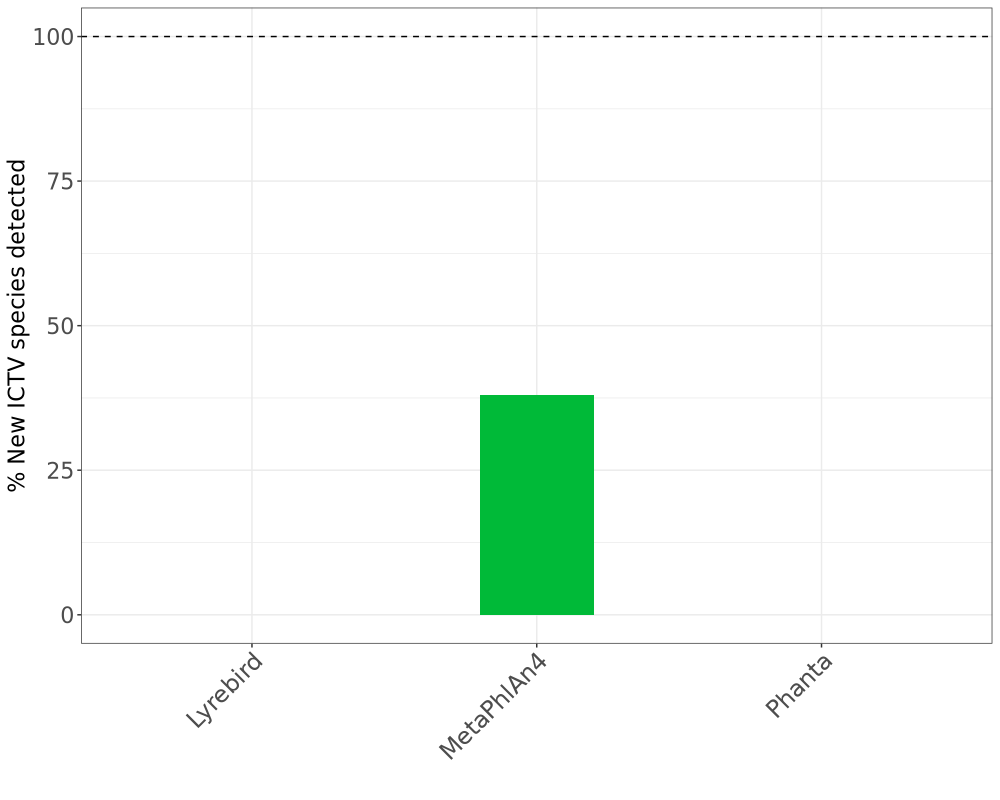

In [22]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)
novelty_counts = fread('6_novel_species_1_component/genome_counter.csv', )
novelty_counts[1,2] = 0

# bar chart, add line at 100
novelty_counts$tool <- name_to_publication_name(novelty_counts$tool)

novelty_counts$tool <- factor(novelty_counts$tool, levels=publication_names$publication_name)

ggplot(novelty_counts, aes(x = tool, y = count, fill = tool)) +
    geom_bar(stat = "identity", width = 0.4) +  # Adjust the width parameter here
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 17)) +  # Increase the label size here
    labs(y = "% New ICTV species detected", x = "") +
    theme(axis.title = element_text(size = 16)) +  # Increase the axis title size here
    theme(legend.position = "none") +
    geom_hline(yintercept = 100, linetype = "dashed", color = "black") +
    ylim(0, 100) + 
    theme(axis.text = element_text(size = 16))  # Increase the size of axis numbers here


In [19]:
novelty_counts

tool,count
<fct>,<int>
Lyrebird,0
MetaPhlAn4,38


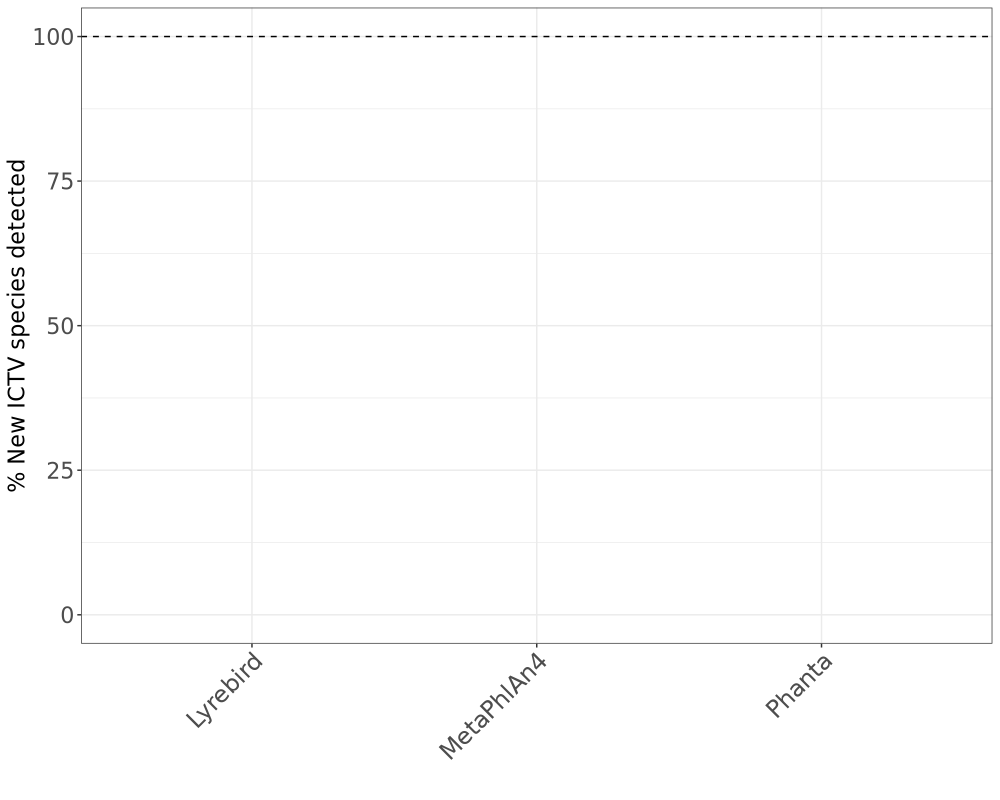

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)
novelty_counts = fread('6_novel_species_1_component/genome_counter.csv', )
novelty_counts[1,2] = 0
novelty_counts[2,2] = 0

# bar chart, add line at 100
novelty_counts$tool <- name_to_publication_name(novelty_counts$tool)

novelty_counts$tool <- factor(novelty_counts$tool, levels=publication_names$publication_name)

ggplot(novelty_counts, aes(x = tool, y = count, fill = tool)) +
    geom_bar(stat = "identity", width = 0.4) +  # Adjust the width parameter here
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 17)) +  # Increase the label size here
    labs(y = "% New ICTV species detected", x = "") +
    theme(axis.title = element_text(size = 16)) +  # Increase the axis title size here
    theme(legend.position = "none") +
    geom_hline(yintercept = 100, linetype = "dashed", color = "black") +
    ylim(0, 100) + 
    theme(axis.text = element_text(size = 16))  # Increase the size of axis numbers here


In [22]:
orders = c('kingdom','phylum','class','order','family','genus','species')
novelty_benchmark_results[, rank := factor(rank, levels=orders)]
novelty_benchmark_results[, novelty_category := factor(novelty_category, levels=orders)]

novelty_benchmark_results[, tool := factor(tool, levels=tools)]
novel_orders = gsub('^','novel ',orders)
novelty_benchmark_results[, novelty_category_novel := factor(novelty_category_novel, levels=novel_orders)]

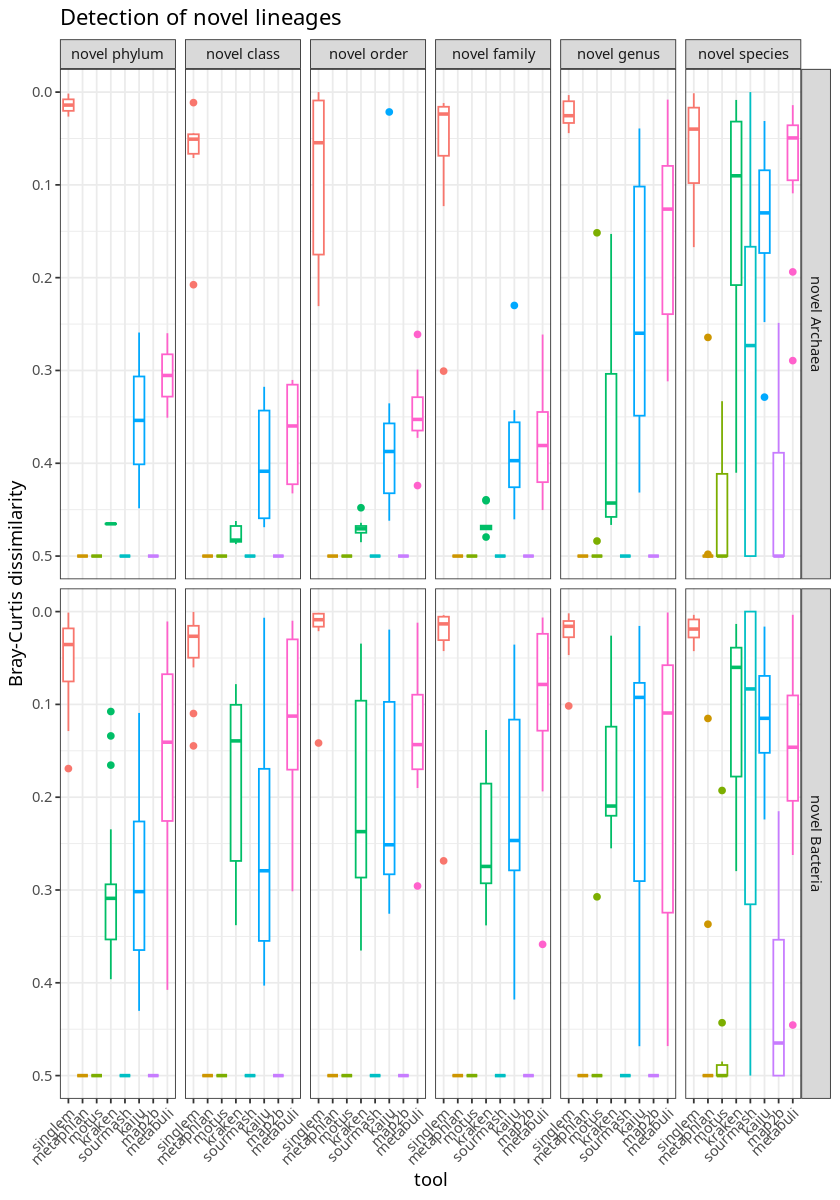

In [23]:
qplot(data=novelty_benchmark_results[rank=='kingdom'], tool, value, geom='boxplot', main='Detection of novel lineages', colour=tool, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

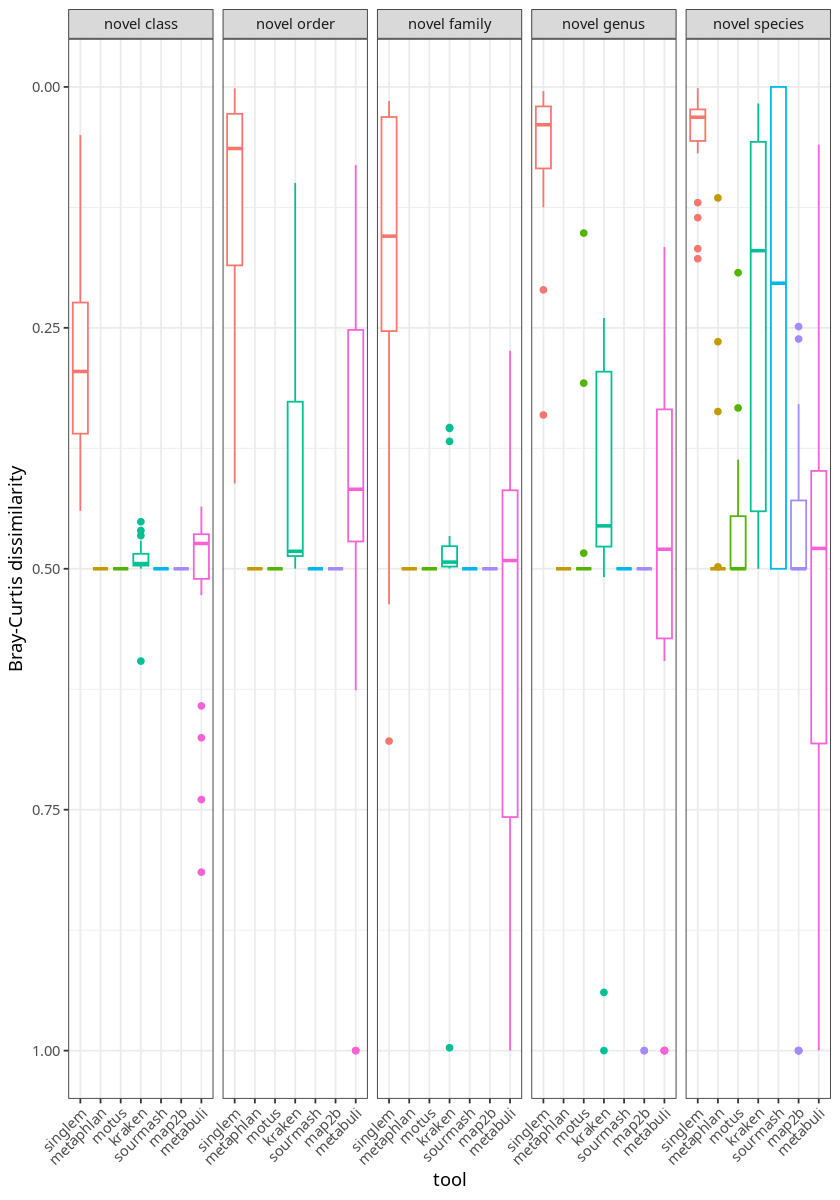

In [24]:
# What about when the rank equals one level above the novelty category?

# novelty_benchmark_results
# novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]]
qplot(data=novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]], colour=tool, ylab='Bray-Curtis dissimilarity', tool, value, geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

In [25]:
# Read non-novelty results
marine = fread('1_novel_strains/bray-curtis.csv')

In [26]:
runtimes = fread('1_novel_strains/runtime.csv')

In [28]:
novelty_benchmark_results[, tool2 := name_to_publication_name(tool)]
marine[, tool2 := name_to_publication_name(tool)]
runtimes[, tool2 := name_to_publication_name(tool)]

my_colours = c(
#1b9e77 Dark2
#d95f02
#7570b3
#e7298a
#66a61e
#e6ab02
#a6761d
#666666
'#e7298a',
'#1b9e77',
'#d95f02',
'#7570b3',
'#66a61e',
'#e6ab02',
'#a6761d',
'#666666'

#     '#e7298a','#1b9e77', #?
# '#d95f02',
# '#7570b3',

# '#66a61e',
# '#e6ab02'
)
options(repr.plot.width=7, repr.plot.height=10)

# library(ggbreak)
runtimes2 = runtimes[threads==1, .(mins=mean(s/60), max_rss=mean(max_rss/1000)), by=.(tool2)]

In [29]:
# ggbreak doesn't get applied so can't use ggarrange


# rp = qplot(data=runtimes2, xlab='', tool2, mins, geom='col', fill=tool2, ylab='Runtime (mins)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+scale_y_break(c(750,6200))

# library(patchwork)

# ggarrange(
#     qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse(),

#     qplot(data=novelty_benchmark_results[tool != 'kaiju'][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse() +scale_color_manual(breaks=tools2_order, values=my_colours),

#     ggarrange(
#         qplot(data=marine[rank=='species'], xlab='', ylim=c(0.6,0), tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         rp,

#         qplot(data=runtimes[threads==1], xlab='', tool2, max_rss/1000, geom='boxplot', colour=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         labels=c('C','D','E'),
#         nrow=1
#     ),

#     nrow=3,
#     labels=c('A','B'),
#     heights=c(2,1.2,1.2)
# )

In [30]:
runtimes[, mean(s/60), by=tool2]

tool2,V1
<fct>,<dbl>
SingleM,9.270211
MetaPhlAn,22.341895
mOTUs,17.866923
Kraken2,11.180433
sourmash,61.617167
Kaiju,16.832812
MAP2B,88.773832
Metabuli,32.540987


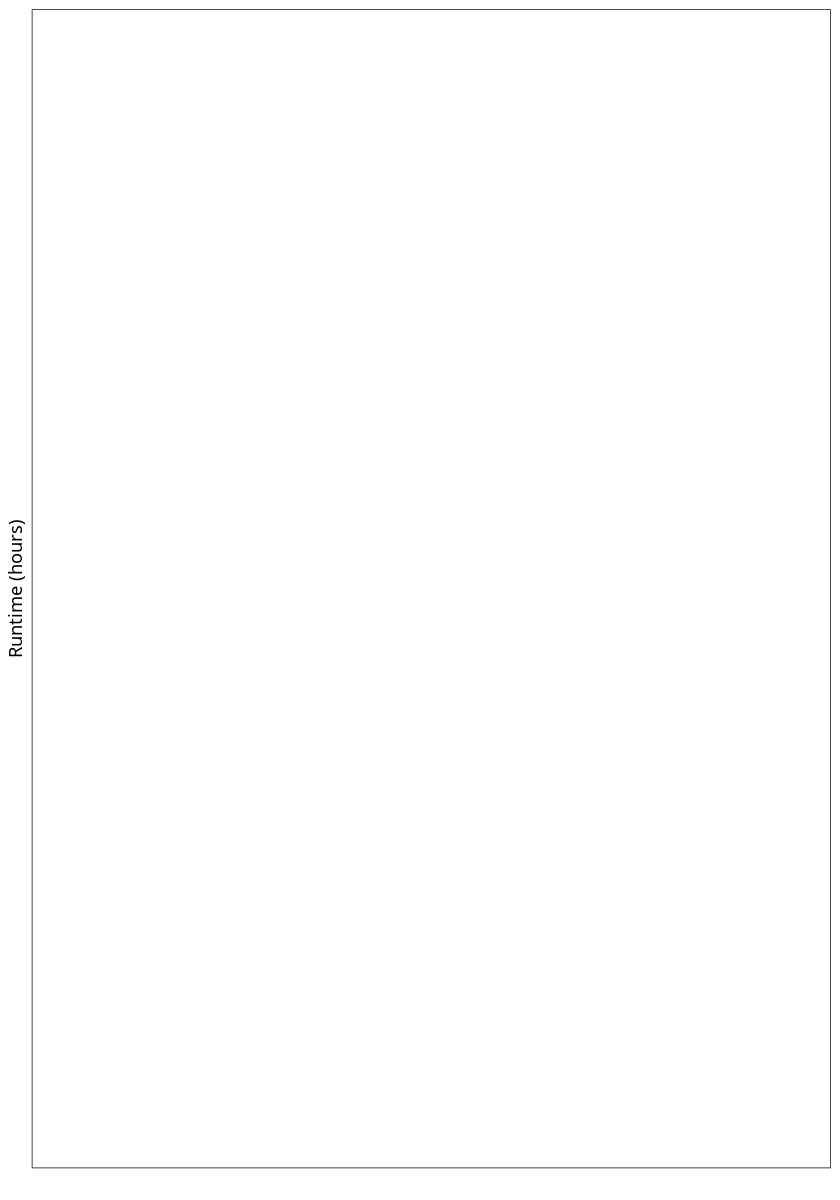

In [31]:
qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)#+scale_y_break(c(750,6200))

In [32]:
library(patchwork)

plot1 = qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse() +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

plot2 = qplot(data=novelty_benchmark_results[tool %in% correct_taxonomy_tools][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse() +scale_color_manual(breaks=tools2_order, values=my_colours)

plot31 = qplot(data=marine[rank=='species'], xlab='', ylim=c(0.6,0), tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)

plot32 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)#+scale_y_break(c(750,6200))

plot33 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, max_rss, geom='col', fill=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)

(plot31 + plot32 + plot33) / plot2 / plot1 + 
  plot_annotation(tag_levels = list(c('A','B','C','D','E')))+
  plot_layout(heights = c(1,1,2))# & theme(plot.tag=element_text(vjust=-1.5))
# ggsave('fig2.svg', width=7, height=10)
# ggsave('fig2.png', width=7, height=10)

# previously, scale break messes up patchwork, so make 2 plots and combine in inkscape later - no longer need ggbreak so comment bad
# plot_spacer() / (plot_spacer() + plot32 + plot_spacer()) / plot_spacer() + 
# #   plot_annotation(tag_levels = list(c('D')))+
#   plot_layout(heights = c(1.2,1.2,2)) & theme(plot.tag=element_text(vjust=-1.5))
# ggsave('fig2_second_half.svg', width=7, height=10)


ERROR: Error in library(patchwork): there is no package called ‘patchwork’


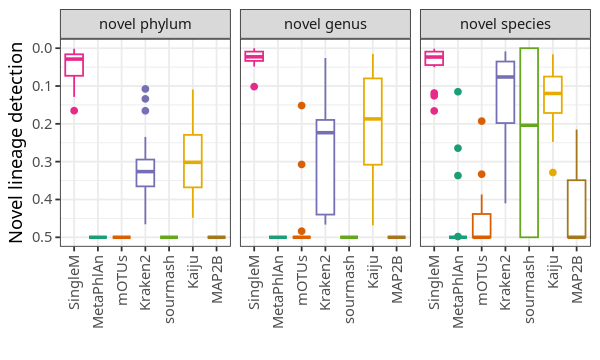

In [ ]:
options(repr.plot.width=5, repr.plot.height=3)
qplot(data=novelty_benchmark_results[rank=='kingdom' & novelty_category_novel %in% c('novel phylum','novel genus','novel species')], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Novel lineage detection')+facet_grid(.~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse() +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
# ggsave('novel_lineage_detection.svg', width=5, height=3)

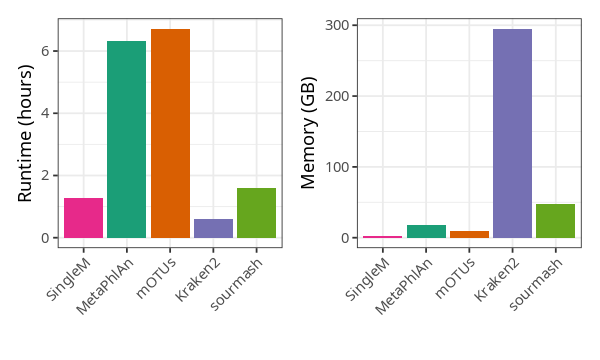

In [ ]:
plot32 + plot33